In [1]:
''# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os, sys
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)



## Téléchargement des données 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
ls '/content/drive/MyDrive/DS_P7/Projet+Mise+en+prod+-+home-credit-default-risk/'

application_test.csv     HomeCredit_columns_description.csv
application_train.csv    installments_payments.csv
bureau_balance.csv       POS_CASH_balance.csv
bureau.csv               previous_application.csv
credit_card_balance.csv  sample_submission.csv


In [4]:
path1="/content/drive/MyDrive/DS_P7/Projet+Mise+en+prod+-+home-credit-default-risk/"
data_files=list(os.listdir(path1))
df_files=pd.DataFrame(data_files,columns=['File_Name'])
df_files['Size_in_MB']=df_files.File_Name.apply(lambda x:round(os.stat(path1+x).st_size/(1024*1024),2))
df_files

File_Name  Size_in_MB
0  HomeCredit_columns_description.csv        0.04
1             credit_card_balance.csv      404.91
2                  bureau_balance.csv      358.19
3                POS_CASH_balance.csv      374.51
4                application_test.csv       25.34
5                          bureau.csv      162.14
6               sample_submission.csv        0.51
7           installments_payments.csv      689.62
8            previous_application.csv      386.21
9               application_train.csv      158.44

In [5]:

default_dir = '/content/drive/MyDrive/DS_P7/Projet+Mise+en+prod+-+home-credit-default-risk/'

app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))


print(f'Training Data Shape: {app_train.shape}')
print(f'Testing Data Shape: {app_test.shape}')

app_train.head() 

Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

application_train/application_test : les principales données de formation et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de la demande de formation sont accompagnées de la CIBLE indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.

In [6]:
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [7]:

app_previous = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
print(f'app previous Shape: {app_previous.shape}')

installments_payments = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'))
print(f'installments payments Shape: {installments_payments.shape}')

sample_submission = pd.read_csv(os.path.join(default_dir,'sample_submission.csv'))
print(f'sample submission Shape: {sample_submission.shape}')

bureau = pd.read_csv(os.path.join(default_dir,'bureau.csv'))
print(f'bureau Shape: {bureau.shape}')

bureau_balance = pd.read_csv(os.path.join(default_dir,'bureau_balance.csv'))
print(f'bureau balance Shape: {bureau_balance.shape}')

POS_CASH_balance = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'))
print(f'POS CASH balance Shape: {POS_CASH_balance.shape}')

credit_card_balance = pd.read_csv(os.path.join(default_dir,'credit_card_balance.csv'))
print(f'credit card balance Shape: {credit_card_balance.shape}')


app previous Shape: (1670214, 37)
installments payments Shape: (13605401, 8)
sample submission Shape: (48744, 2)
bureau Shape: (1716428, 17)
bureau balance Shape: (27299925, 3)
POS CASH balance Shape: (10001358, 8)
credit card balance Shape: (3840312, 23)


<function matplotlib.pyplot.show(*args, **kw)>

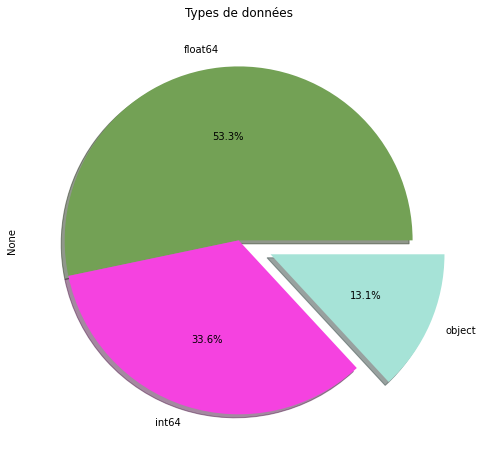

In [8]:
plt.figure(figsize=(12, 8))
app_train.dtypes.value_counts().plot.pie(explode=(0, 0, 0.2),autopct='%1.1f%%', colors=['#73a155','#f542e0', '#A6E3D7'],shadow=True)
plt.title("Types de données")
plt.show

# Analyse Exploratoire
La cible est ce qu'on nous demande de prévoir : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie

In [9]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0.5, 1.0, '0 = loan was repaid on time,  1 = client had payment difficulties.')

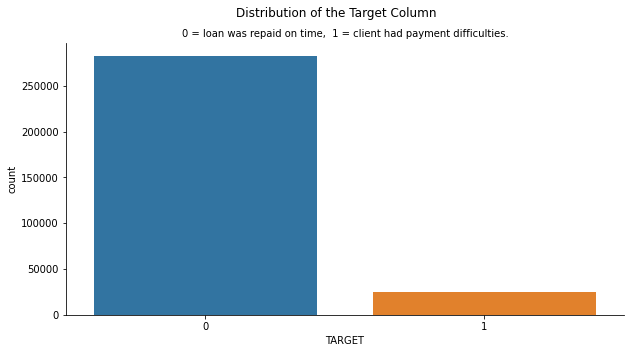

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x=app_train['TARGET'])
sns.despine()

plt.suptitle('Distribution of the Target Column', fontsize = 12)
plt.title('0 = loan was repaid on time,  1 = client had payment difficulties.', fontsize = 10)


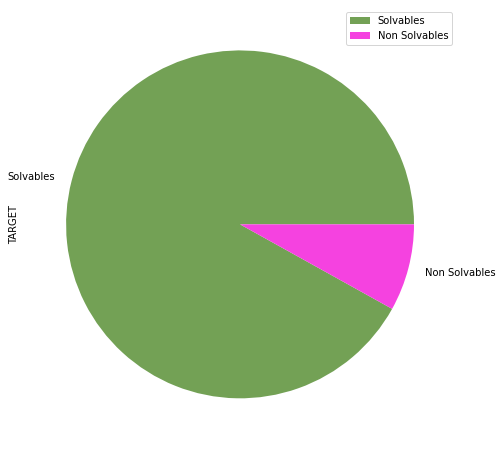

In [11]:
# Affiche l'histogramme du nombre de jours employés
plt.figure(figsize=(12, 8))
app_train.TARGET.value_counts().plot(kind='pie',  colors=['#73a155', '#f542e0'], labels=["Solvables", "Non Solvables"])
plt.legend()
plt.show()

## Valeurs manquantes

In [12]:
print(app_train.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


In [13]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [14]:
# Nombre de classes uniques dans chaque colonne d'objet 
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [16]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [17]:
missing_values.index

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'LANDAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
       'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'LIVINGAREA_MEDI',
       'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_AVG'

Text(0.5, 0, 'Nom de la colonne')

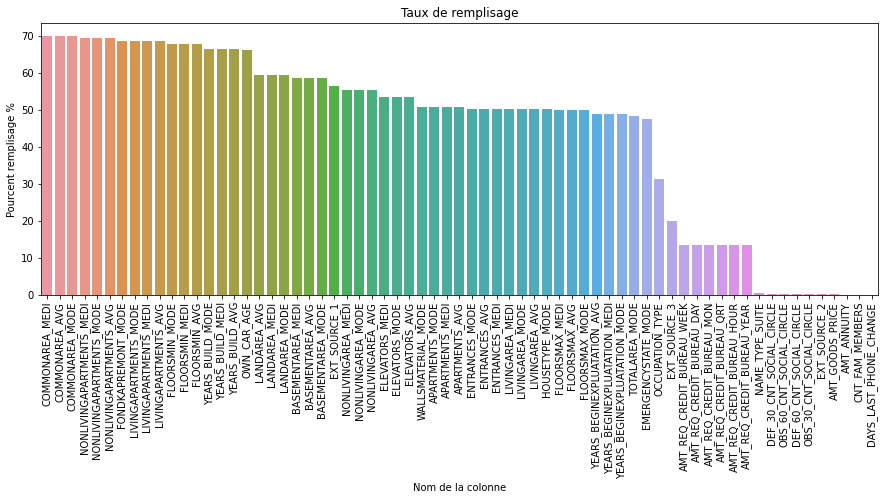

In [18]:
plt.figure(figsize=(15, 5))
plt.title('Taux de remplisage')
sns.barplot(x=missing_values.index, y=missing_values['% of Total Values'])
plt.xticks(rotation=90)
plt.ylabel('Pourcent remplisage %')
plt.xlabel("Nom de la colonne")

In [19]:
def plot_feat(df:pd.DataFrame,feature:str,label_rotation=False,horizontal_layout=True):
    temp = df[feature].fillna('Unknown').value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    df1.sort_values(by=feature, inplace=True)

    # Calculate the percentage of each category with target=1
    cat_perc = df[[feature, 'TARGET']].fillna("Unknown").groupby([feature],as_index=False).mean()
    cat_perc['TARGET']*=100
    cat_perc.sort_values(by=feature, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1, color = 'blue')
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    ax1.set_title('Nombre de contrats par catégorie')
    sns.despine()

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc, color = 'green')
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    ax2.set_ylabel('Pourcentage de la catégorie avec target valeur 1 [%]')
    ax2.set_title('Pourcentage de prêts en défaut de paiement')
    sns.despine()

    plt.suptitle(f"Contrats par catégorie de fonctionnalité '{feature}'")
    

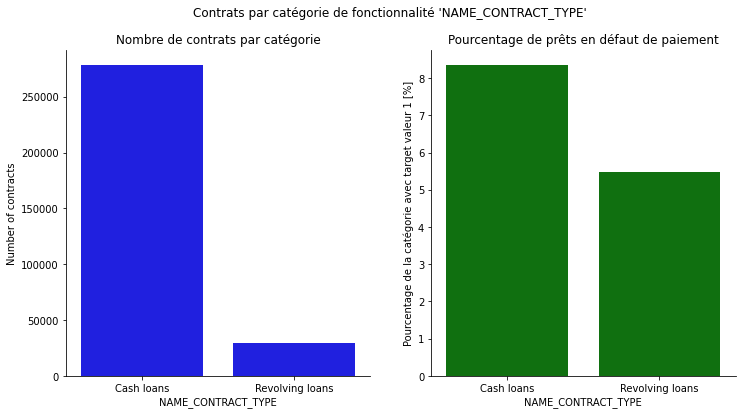

In [20]:
# Type de contrat
plot_feat(app_train, 'NAME_CONTRACT_TYPE')

On peut voir que la plupart des prêts que les clients prennent sont des prêts cash.
moin 6% des personnes ont contracté un prêt revolving.

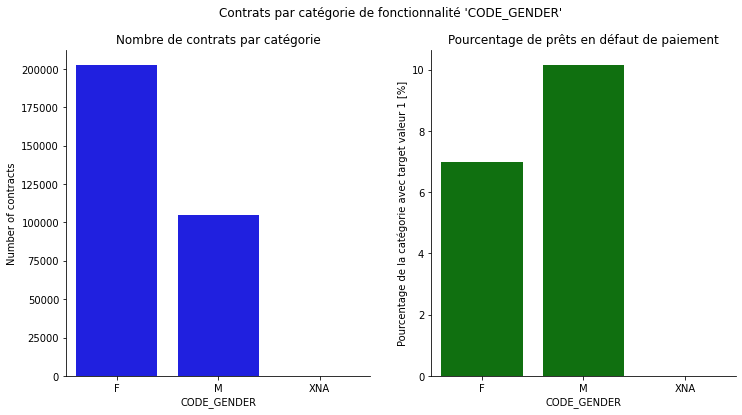

In [ ]:
plot_feat(app_train, 'CODE_GENDER')


Le premier point à observer est qu'il y a 4 lignes dans la table application_train qui ont des genres "XNA".
Dans le subplot 1, nous constatons que pour l'ensemble de données donné, il y a plus de candidats féminins  que de candidats masculins.
Cependant, contrairement au nombre de candidates, nous constatons, à partir du deuxième subplot, que les candidats masculins ont tendance à être plus défaillants (10,14%) que les candidates féminines (7%).
Ainsi, on peut dire que les hommes ont plus tendance à ne pas payer leurs dettes que les femmes selon l'ensemble de données donné.

In [21]:
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']
app_test = app_test[app_test['CODE_GENDER'] != 'XNA']

Pour la variable 'NAME_INCOME_TYPE' :
La colonne 'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour le jeu d'entrainement et pour seulement 5 emprunteurs que nous allons supprimé.

In [22]:
app_train['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [23]:
app_test['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Pensioner', 'Commercial associate',
       'Businessman', 'Student', 'Unemployed'], dtype=object)

In [24]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
#app_train = app_train[app_train['NAME_INCOME_TYPE'] != 'Maternity leave']

 Pour la colonne NAME_FAMILY_STATUS, il y a seulement deux fois la valeur Unknown et uniquement pour le jeu d'entrainement. Les lignes correspondantes sont supprimées

In [25]:
app_train['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [26]:
app_test['NAME_FAMILY_STATUS'].unique()

array(['Married', 'Single / not married', 'Civil marriage', 'Widow',
       'Separated'], dtype=object)

In [27]:
# Supprime les individus dont la statut familial est inconnu
app_train = app_train[app_train['NAME_FAMILY_STATUS'] != 'Unknown']

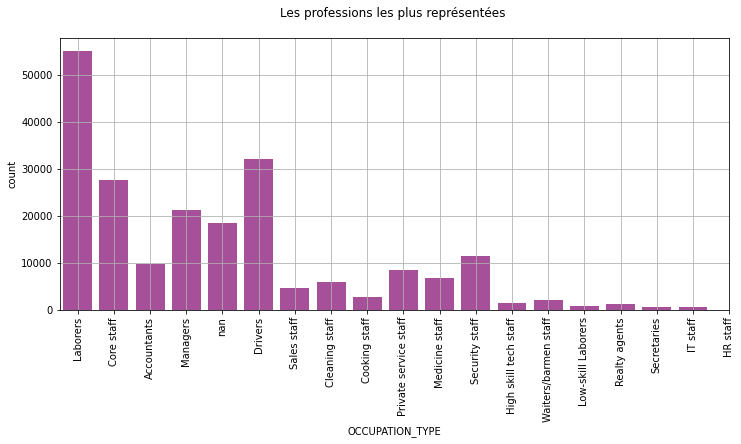

In [28]:
(fig, ax) = plt.subplots(figsize=(12, 5))
plt.title("Les professions les plus représentées \n")
sns.countplot(data=app_train, x=app_train["OCCUPATION_TYPE"],  color="#b541a4")
plt.xticks(range(0,app_train["OCCUPATION_TYPE"].nunique()+1) ,app_train["OCCUPATION_TYPE"].unique(),rotation=90)
plt.grid()

### Alignement des données de train et de test
Il doit y avoir les mêmes caractéristiques (colonnes) dans les données de formation et de test. L'encodage à chaud a créé plus de colonnes dans les données d'apprentissage car il y avait des variables catégorielles avec des catégories non représentées dans les données de test. Pour supprimer les colonnes des données d'entraînement qui ne figurent pas dans les données de test, nous devons aligner les dataframes. Nous extrayons d'abord la colonne cible des données d'apprentissage (car cela ne figure pas dans les données de test, mais nous devons conserver ces informations). Lorsque nous faisons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les dataframes en fonction des colonnes et non des lignes

In [29]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307505, 122)
Testing Features shape:  (48744, 121)


### Traitement des outliers
### Anomalies
Numéros mal saisis, erreurs dans l'équipement de mesure ou mesures extrêmes.

In [30]:
(app_train['DAYS_BIRTH'] / -365).describe()


count    307505.000000
mean         43.937122
std          11.956131
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure.

In [31]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307505.000000
mean       -174.839312
std         387.059825
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

10       365243
17       365243
22       365243
26       365243
36       365243
          ...  
48717    365243
48728    365243
48731    365243
48735    365243
48736    365243
Name: DAYS_EMPLOYED, Length: 9274, dtype: int64

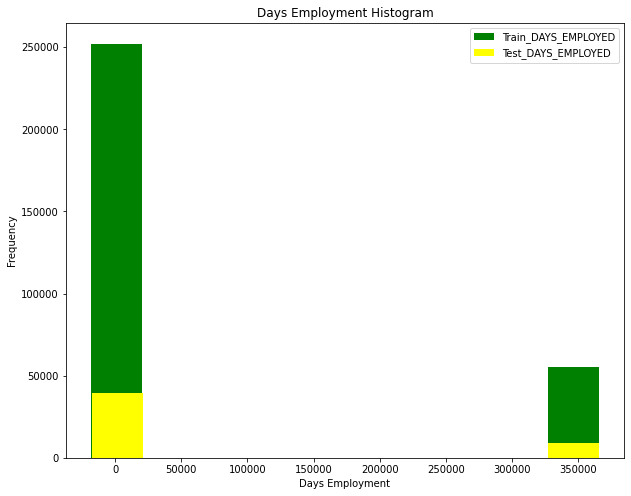

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram', color = "green", label='Train_DAYS_EMPLOYED')
app_test['DAYS_EMPLOYED'].plot.hist(color = "yellow", label='Test_DAYS_EMPLOYED')
plt.xlabel('Days Employment')
plt.legend()
app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] > 200000]


sous-divisons les clients anormaux et voyons s'ils ont tendance à avoir des taux de défaut plus élevés ou plus faibles que le reste des clients

In [33]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaut plus faible. Nous allons remplir les valeurs anormales sans nombre (np.nan) puis créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

Il y a 0 anomalies dans les données de test sur 48744 entrées



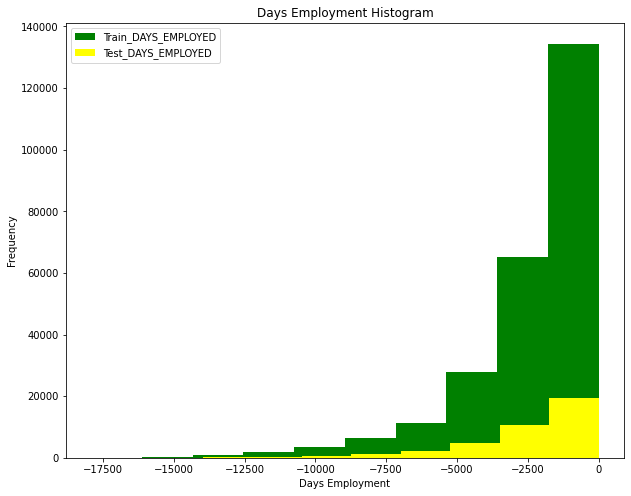

In [35]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

plt.figure(figsize=(10, 8))
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram',color = "green", label='Train_DAYS_EMPLOYED')
app_test['DAYS_EMPLOYED'].plot.hist(color = "yellow", label='Test_DAYS_EMPLOYED')
plt.xlabel('Days Employment')
plt.legend()

print('Il y a %d anomalies dans les données de test sur %d entrées\n' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

In [36]:
# Sauvegarde des données non encore encodées

output_dir = '/content/drive/MyDrive/DS_P7/'
app_train.to_csv(os.path.join(output_dir,'app_train_no_encoded_no_featureengineering.csv'), index=False)
app_test.to_csv(os.path.join(output_dir,'app_test_no_encoded_no_featureengineering.csv'), index=False)


## Correlations


In [37]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037611
DAYS_REGISTRATION              0.041978
FLAG_DOCUMENT_3                0.044338
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045985
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055220
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074959
DAYS_BIRTH                     0.078244
TARGET                         1.000000
DAYS_EMPLOYED_ANOM                  NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160470
EXT_SOURCE_1                 -0.155316
FLOORSMAX_AVG                -0.044007
FLOORSMAX_MEDI               -0.043771
FLOORSMAX_MODE               -0.043230
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225


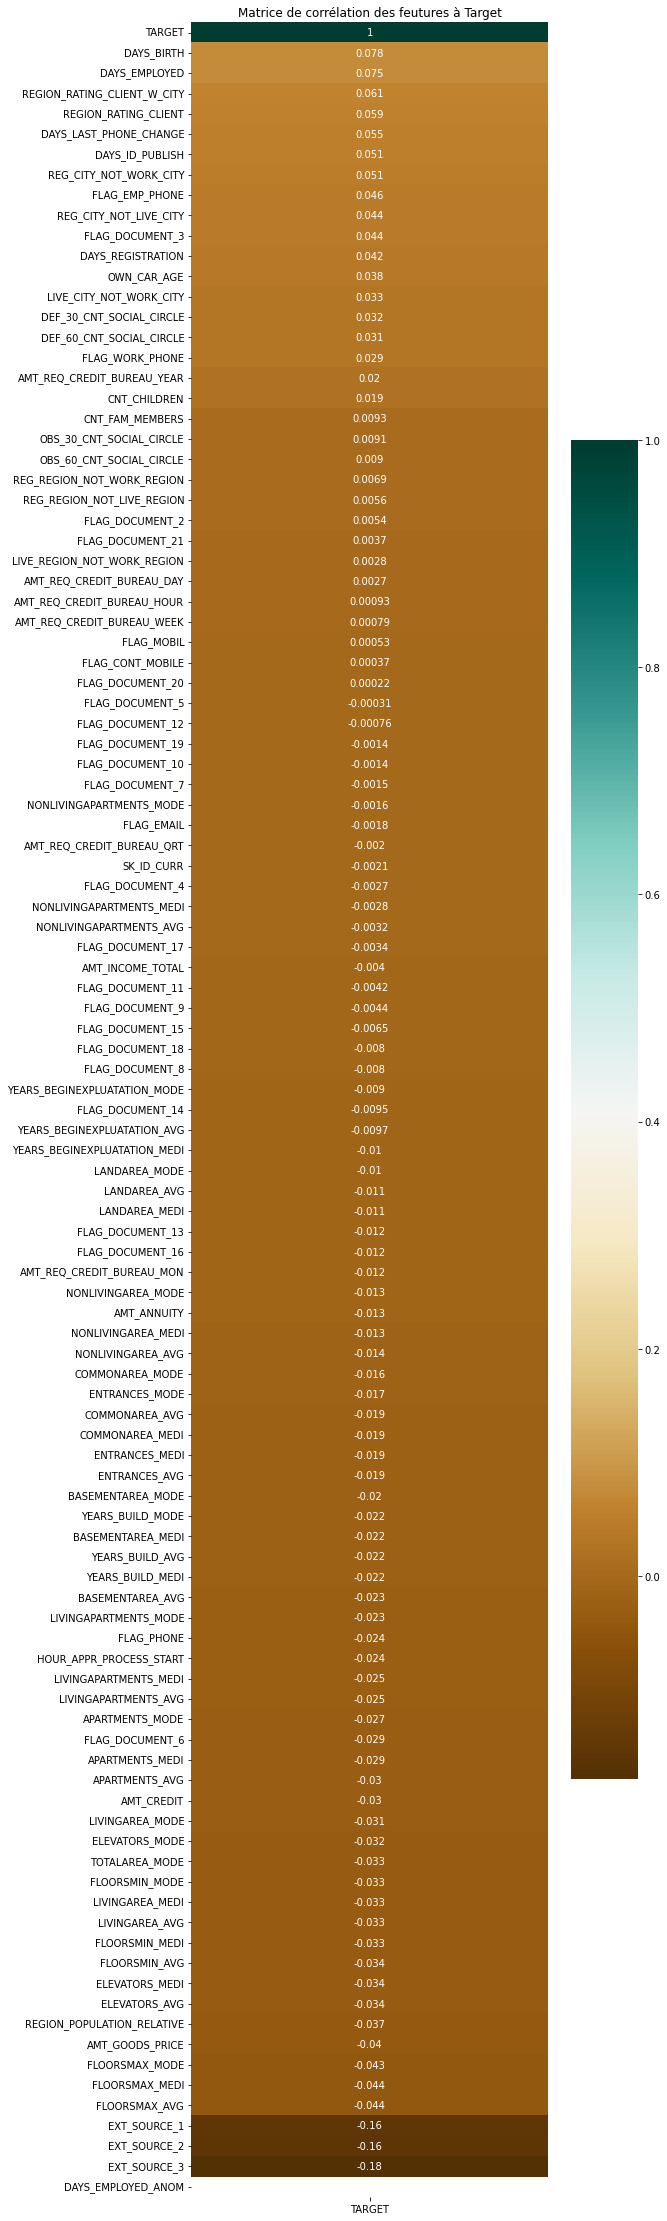

In [39]:
plt.figure(figsize=(8, 40))
heatmap = sns.heatmap(app_train.corr()[['TARGET']] .sort_values(by='TARGET', ascending=False), annot=True, cmap='BrBG')
heatmap.set_title('Matrice de corrélation des feutures à Target', fontdict={'fontsize':12});

### Effet de l'âge sur le remboursement

In [40]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07824384822893453

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

### Répartition de l'âge

Text(0, 0.5, 'Count')

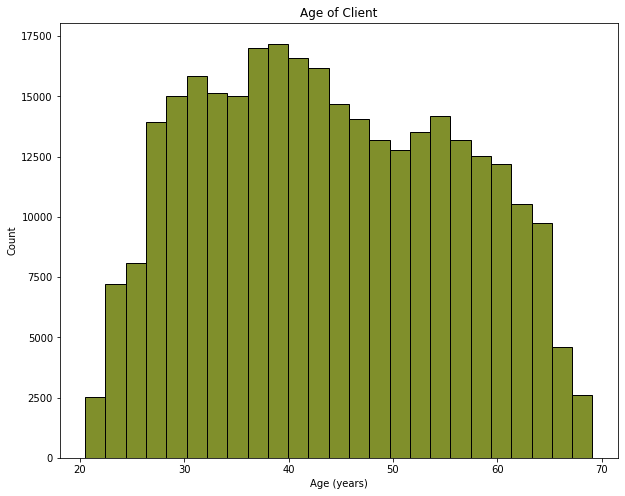

In [41]:
# Plot the distribution of ages in years
plt.figure(figsize=(10, 8))
plt.hist(app_train['DAYS_BIRTH'] / 365, color = '#808f2b', edgecolor = 'black', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

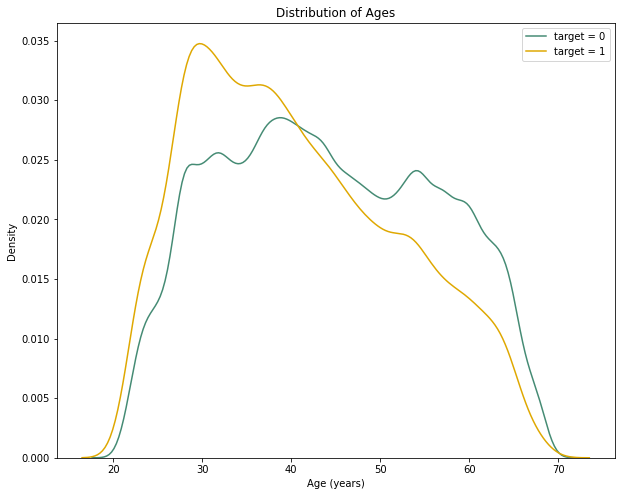

In [42]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target = 0', color = '#458b74')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target = 1',  color = '#dfa801')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

La courbe cible == 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Regardons cette relation sous un autre angle : incapacité moyenne à rembourser les crédits par tranche d'âge.

Pour faire ce graphique, nous avons d'abord découpé la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque bin, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge

In [43]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [44]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111442  10155.219690    27.822520
(30.0, 35.0]  0.102817  11854.834656    32.478999
(35.0, 40.0]  0.089418  13707.928195    37.555968
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055316  20984.285455    57.491193
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

Text(0.5, 1.0, "Défaut de remboursement par groupe d'âge")

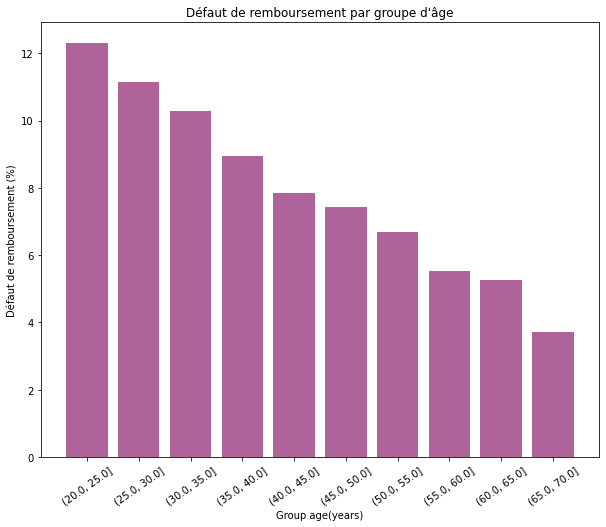

In [45]:
plt.figure(figsize = (10, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'], color = '#ae639b')

# Plot labeling
plt.xticks(rotation = 35)
plt.xlabel('Group age(years)')
plt.ylabel('Défaut de remboursement (%)')
plt.title("Défaut de remboursement par groupe d'âge")

 les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux d'impayés est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus élevée.

### Sources extérieures
Les 3 variables avec les plus fortes corrélations négatives avec Target sont EXT_SOURCE_1, EXT_SOURCE_2,  EXT_SOURCE_3

In [46]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155316     -0.160470     -0.178926   -0.078244
EXT_SOURCE_1 -0.155316      1.000000      0.213979      0.186845    0.600625
EXT_SOURCE_2 -0.160470      0.213979      1.000000      0.109180    0.092014
EXT_SOURCE_3 -0.178926      0.186845      0.109180      1.000000    0.205468
DAYS_BIRTH   -0.078244      0.600625      0.092014      0.205468    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

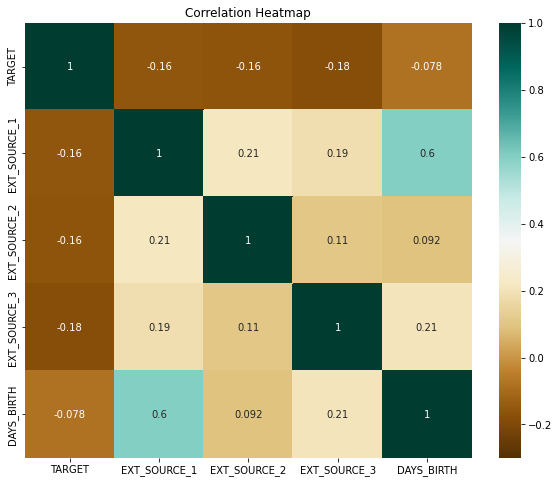

In [48]:
# Heatmap of correlations
plt.figure(figsize = (10, 8))
#mask = np.triu(ext_data_corrs)

sns.heatmap(ext_data_corrs,  cmap='BrBG', vmin = -0.3, annot = True, vmax = 1)
plt.title('Correlation Heatmap')


Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique qu'à mesure que la valeur de EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1 indiquant que peut-être l'un des facteurs de ce score est l'âge du client

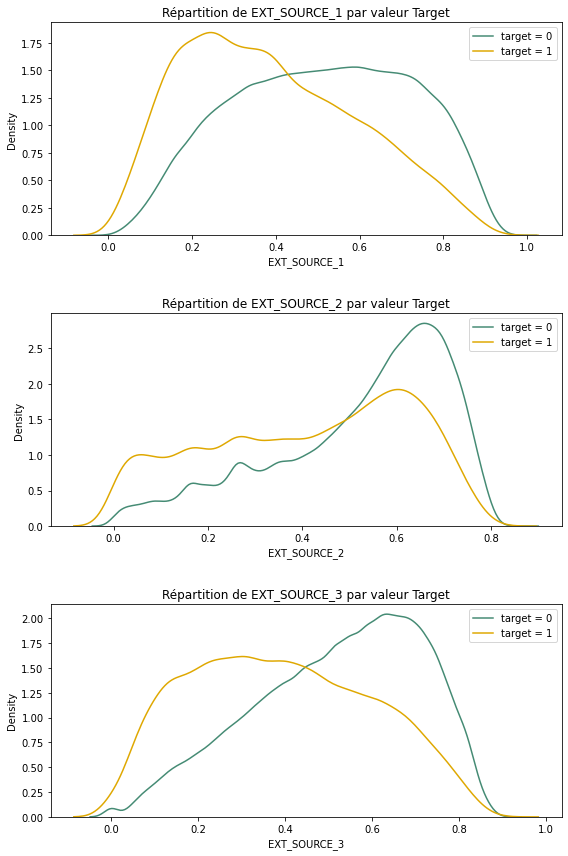

In [49]:
plt.figure(figsize = (8, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target = 0', color = '#458b74')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target = 1', color = '#dfa801')
    
    # Label the plots
    plt.title('Répartition de %s par valeur Target' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 3)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible, cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserW

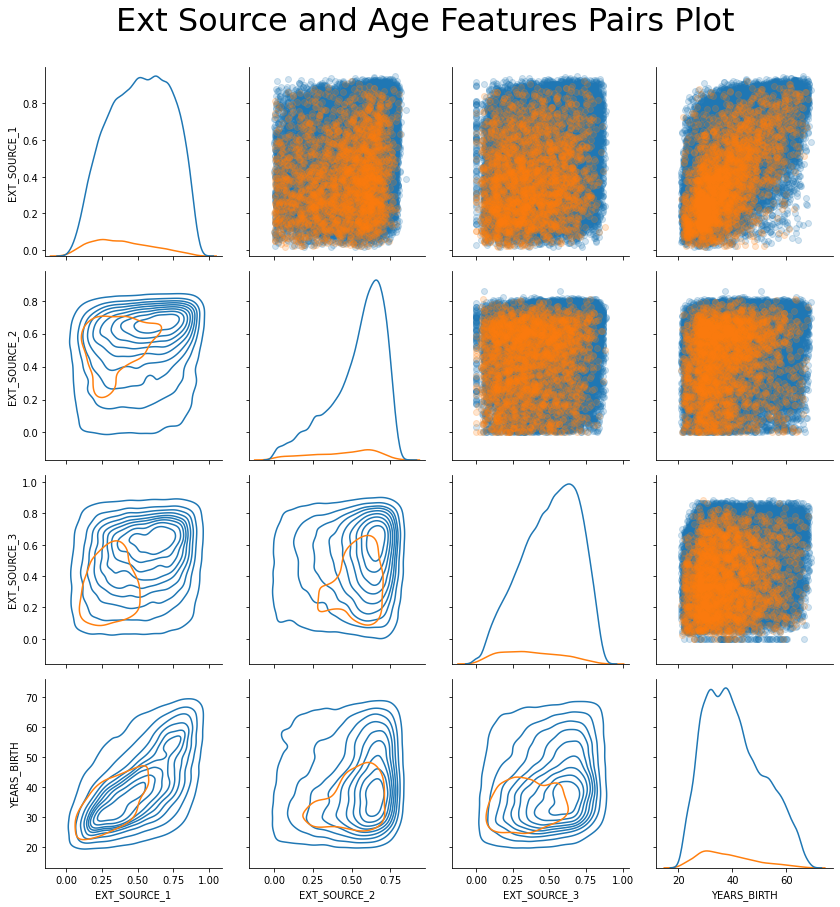

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Feature Engineering
CREDIT_INCOME_PERCENT: 
le pourcentage du montant du crédit par rapport au revenu d'un client

ANNUITY_INCOME_PERCENT: le pourcentage de l'annuité du prêt par rapport au revenu du client

CREDIT_TERM: la durée du paiement en mois (puisque l'annuité est le montant mensuel dû

DAYS_EMPLOYED_PERCENT: le pourcentage des jours employés par rapport à l'âge du client

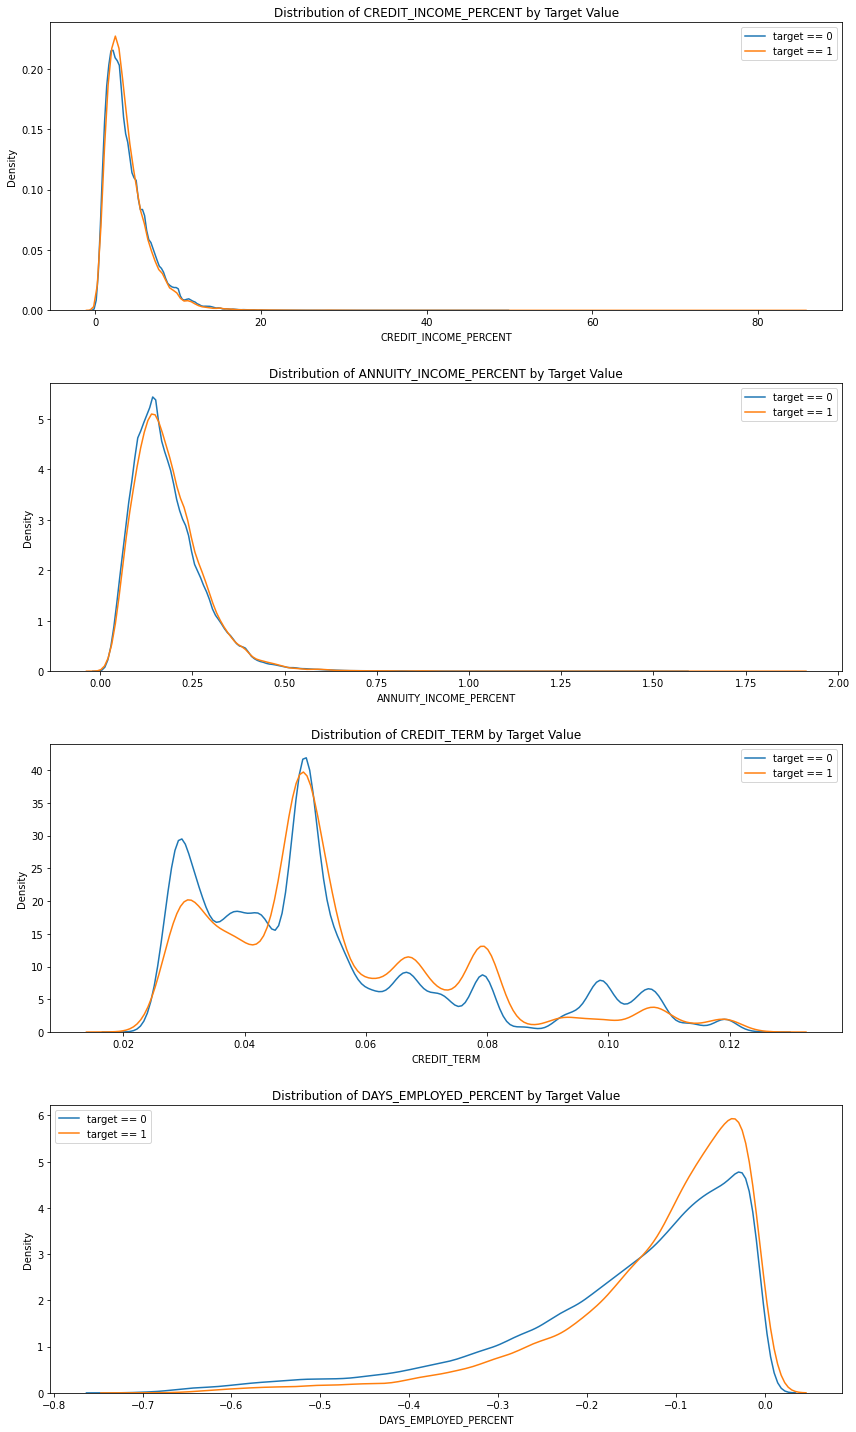

In [50]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()


app_train_domain['INCOME_TO_ANNUITY_RATIO'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['AMT_ANNUITY']
app_train_domain['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app_train_domain['INCOME_TO_ANNUITY_RATIO'] * app_train_domain['DAYS_BIRTH']
app_train_domain['INCOME_PER_PERSON'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['CNT_FAM_MEMBERS']
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['PAYMENT_RATE'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']


app_test_domain['INCOME_TO_ANNUITY_RATIO'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['AMT_ANNUITY']
app_test_domain['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app_test_domain['INCOME_TO_ANNUITY_RATIO'] * app_test_domain['DAYS_BIRTH']
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
app_test_domain['INCOME_PER_PERSON'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['CNT_FAM_MEMBERS']
app_test_domain['PAYMENT_RATE'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']

plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # matplotlib.pyplot.legend
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
# Sauvegarde des résultats

output_dir = '/content/drive/MyDrive/DS_P7/'
app_train_domain.to_csv(os.path.join(output_dir,'app_train_domain_no_enconded_featureengineering.csv'), index=False)
app_test_domain.to_csv(os.path.join(output_dir,'app_test_domain_no_enconded_featureengineering.csv'), index=False)


# Traitement des valeurs manquantes

In [51]:
missing_values_table(app_train_domain)

Your selected dataframe has 131 columns.
There are 73 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_AVG                          214861               69.9
COMMONAREA_MODE                         214861               69.9
COMMONAREA_MEDI                         214861               69.9
NONLIVINGAPARTMENTS_AVG                 213511               69.4
NONLIVINGAPARTMENTS_MODE                213511               69.4
...                                        ...                ...
AMT_ANNUITY                                 12                0.0
INCOME_TO_ANNUITY_RATIO_BY_AGE              12                0.0
INCOME_TO_ANNUITY_RATIO                     12                0.0
PAYMENT_RATE                                12                0.0
DAYS_LAST_PHONE_CHANGE                       1                0.0

[73 rows x 2 columns]

In [52]:
missing_values_table(app_test_domain)

Your selected dataframe has 130 columns.
There are 71 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MODE                          33495               68.7
COMMONAREA_MEDI                          33495               68.7
COMMONAREA_AVG                           33495               68.7
NONLIVINGAPARTMENTS_MEDI                 33347               68.4
NONLIVINGAPARTMENTS_AVG                  33347               68.4
...                                        ...                ...
AMT_ANNUITY                                 24                0.0
INCOME_TO_ANNUITY_RATIO_BY_AGE              24                0.0
INCOME_TO_ANNUITY_RATIO                     24                0.0
PAYMENT_RATE                                24                0.0
EXT_SOURCE_2                                 8                0.0

[71 rows x 2 columns]

### Suppression des valeurs manquantes de plus 90%

In [53]:
# suppression des colonnes avec plus de 90% de valeurs manquantes pour les données d'entrainement
app_train_domain = app_train_domain.loc[:, app_train_domain.isnull().mean() <.90]

In [54]:
# suppression des colonnes avec plus de 90% de valeurs manquantes pour les données test
app_test_domain = app_test_domain.loc[:, app_test_domain.isnull().mean() <.90]

### Encodage des variables catégorielles
Les variables catégorielles doivent être encodés pour être utilisables par les modèles. nous utiliserons Label Encoding pour toutes les variables catégorielles avec seulement 2 catégories et One-Hot Encoding pour toutes les variables catégorielles avec plus de 2 catégories

In [55]:
# Séparation des variables catégorielles et numériques
num_var = app_train_domain.select_dtypes(include=['int64','float64'])
cat_var = app_train_domain.select_dtypes(exclude=['int64','float64']) 
print(cat_var.columns.tolist())
print('='*100)
print(num_var.columns.tolist())

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DAYS_EMPLOYED_ANOM']
['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_

### Label Encoding

In [56]:
# one-hot encoding of categorical variables
app_train_domain = pd.get_dummies(app_train_domain)
app_test_domain = pd.get_dummies(app_test_domain)

print('Training Features shape: ', app_train_domain.shape)
print('Testing Features shape: ', app_test_domain.shape)

Training Features shape:  (307505, 253)
Testing Features shape:  (48744, 251)


In [57]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_domain:
    if app_train_domain[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_domain[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_domain[col])
            # Transform both training and testing data
            app_train_domain[col] = le.transform(app_train_domain[col])
            app_test_domain[col] = le.transform(app_test_domain[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


### One-Hot Encoding

In [58]:
# One-hot encoding pour les colonnes catégorielles
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [75]:
# Appel à la fonction Enconder des variables catégorielles
app_train_domain = one_hot_encoder(app_train_domain)
app_test_domain = one_hot_encoder(app_test_domain)

In [60]:
app_train_domain.head(3)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002             0          202500.0    406597.5      24700.5   
1      100003             0          270000.0   1293502.5      35698.5   
2      100004             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801        9461         -637.0   
1        1129500.0                    0.003541       16765        -1188.0   
2         135000.0                    0.010032       19046         -225.0   

   DAYS_REGISTRATION  ...  HOUSETYPE_MODE_terraced house  \
0            -3648.0  ...                              0   
1            -1186.0  ...                              0   
2            -4260.0  ...                              0   

   WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                         0                         0   
1                         1                         0   
2                         0                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                          0                       1                        0  
1                          0                       1                        0  
2                          0                       0                        0  

[3 rows x 253 columns]

In [ ]:
# Sauvegarde des données

output_dir = '/content/drive/MyDrive/DS_P7/'
app_train_domain.to_csv(os.path.join(output_dir,'app_train_encoded.csv'), index=False)
app_test_domain.to_csv(os.path.join(output_dir,'app_test_encoded.csv'), index=False)




---
---
---


## Preprocessing et Fusion des tables
Les procédures de fusion des tables ci-dessous sont basés sur le pipeline de feature engineering présenté dans :

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [61]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(data_dir= path1, num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(f'{data_dir}/bureau.csv', nrows=num_rows)
    print(
        f'Read bureau samples: {len(bureau)} rows, {len(bureau.columns)} columns')
    bureau_balance = pd.read_csv(f'{data_dir}/bureau_balance.csv', nrows=num_rows)
    print(
        f'Read bureau balance samples: {len(bureau_balance)} rows, {len(bureau_balance.columns)} columns')
    bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bureau_balance_cat:
        bureau_balance_aggregations[col] = ['mean']
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
    bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bureau_balance_agg.columns.tolist()])
    bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bureau_balance, bureau_balance_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bureau_balance_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [62]:
# Preprocess previous_applications.csv
def previous_applications(data_dir= path1 , num_rows=None, nan_as_category=True):
    app_previous = pd.read_csv(f'{data_dir}/previous_application.csv', nrows=num_rows)
    print(
        f'Read previous application samples: {len(app_previous)} rows, {len(app_previous.columns)} columns')
    app_previous, cat_cols = one_hot_encoder(app_previous, nan_as_category=True)
    # Days 365.243 values -> nan
    app_previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    app_previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    app_previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    app_previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    app_previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    app_previous['APP_CREDIT_PERC'] = app_previous['AMT_APPLICATION'] / app_previous['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    app_previous_agg = app_previous.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    app_previous_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in app_previous_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = app_previous[app_previous['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    app_previous_agg = app_previous_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = app_previous[app_previous['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    app_previous_agg = app_previous_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, app_previous
    gc.collect()
    return app_previous_agg

In [63]:
# Preprocess POS_CASH_balance.csv
def pos_cash(data_dir=path1, num_rows=None, nan_as_category=True):
    pos = pd.read_csv(f'{data_dir}/POS_CASH_balance.csv', nrows=num_rows)
    print(
        f'Read POS cash balance samples: {len(pos)} rows, {len(pos.columns)} columns')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [64]:
#Preprocess installments_payments.csv
def installments_payments(data_dir='data', num_rows=None, nan_as_category=True):
    ins = pd.read_csv(f'{data_dir}/installments_payments.csv', nrows=num_rows)
    print(
        f'Read installments payments samples: {len(ins)} rows, {len(ins.columns)} columns')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [65]:
# Preprocess credit_card_balance.csv
def credit_card_balance(data_dir='data', num_rows=None, nan_as_category=True):
    cc = pd.read_csv(f'{data_dir}/credit_card_balance.csv', nrows=num_rows)
    print(
        f'Read credit card balance samples: {len(cc)} rows, {len(cc.columns)} columns')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

## Aggregations

In [66]:
DATA_FOLDER = "/content/drive/MyDrive/DS_P7/Projet+Mise+en+prod+-+home-credit-default-risk/"
def preprocess_pipeline(data_dir=DATA_FOLDER, num_rows=None, debug=False):
    # num_rows = 10000 if debug else None
    print(f'data_dir={data_dir}')
    df = app_train_domain
    start = time.time()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(data_dir, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(data_dir, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(data_dir, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(data_dir, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(data_dir, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # with timer("Reduce field sizes"):
        # fonction reduce_memory a des effets bizarres sur seaborn plots - on la desactive
        # df = outils_preprocess.reduce_memory(df)

    time_taken = time.time() - start
    print(f'preprocessing completed in {time_taken:.0f} s')
    return df

In [67]:
OUT_FOLDER = "/content/drive/MyDrive/DS_P7/"
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'

# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 10000

savepath = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'
if os.path.exists(savepath):
    # reload preprocessed data (< 1 minute)
    print('reloading preprocessed_data (preprocess pipeline has not been modified since last edit)')
    df_data = pd.read_csv(savepath)
else:
    # preprocess pipeline takes several minutes
    df_data = preprocess_pipeline(
        data_dir=DATA_FOLDER, num_rows=None, debug=False)


print(f'df_data.shape = {df_data.shape}')

data_dir=/content/drive/MyDrive/DS_P7/Projet+Mise+en+prod+-+home-credit-default-risk/
Read bureau samples: 1716428 rows, 17 columns
Read bureau balance samples: 27299925 rows, 3 columns
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Read previous application samples: 1670214 rows, 37 columns
Previous applications df shape: (338857, 249)
Process previous_applications - done in 29s
Read POS cash balance samples: 10001358 rows, 8 columns
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 19s
Read installments payments samples: 13605401 rows, 8 columns
Installments payments df shape: (339587, 26)
Process installments payments - done in 35s
Read credit card balance samples: 3840312 rows, 23 columns
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 27s
preprocessing completed in 143 s
df_data.shape = (307505, 803)


In [68]:
# Suppression des valeurs infinis 
def get_columns_with_infinite_values(df):
    res = pd.DataFrame()
    inf_cols = df.columns[np.isinf(df).any()]
    for col in inf_cols:
        inf_rows = np.isinf(df[col]).sum()
        res = res.append(
            {'colonne': col, 'inf_count': inf_rows}, ignore_index=True)
    return res


get_columns_with_infinite_values(df_data)

colonne  inf_count
0     PREV_APP_CREDIT_PERC_MAX        1.0
1  REFUSED_APP_CREDIT_PERC_MAX        1.0
2      INSTAL_PAYMENT_PERC_MAX       18.0

In [69]:
# on remplace les valeurs infinies avec np.nan
def replace_infinite_values_with_nan(df: pd.DataFrame):
    print(f'les valeurs infinite ont bien remplacé')
    return df.replace([np.inf, -np.inf], np.nan)

df_data = replace_infinite_values_with_nan(df_data)

les valeurs infinite ont bien remplacé


In [70]:
df_data.head(3)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002             0          202500.0    406597.5      24700.5   
1      100003             0          270000.0   1293502.5      35698.5   
2      100004             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801        9461         -637.0   
1        1129500.0                    0.003541       16765        -1188.0   
2         135000.0                    0.010032       19046         -225.0   

   DAYS_REGISTRATION  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0            -3648.0  ...                                 NaN   
1            -1186.0  ...                                 NaN   
2            -4260.0  ...                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 NaN                              NaN   
1                                 NaN                              NaN   
2                                 NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  

[3 rows x 803 columns]

On voit qu'il y a les colonnes avec seulement une valeur et puisque l'imputation pour les modèles donne une variable qui est constante et le coefficient de correlation sera NaN, donc on va les supprimer 

In [71]:
def get_single_value_cols(df: pd.DataFrame):
    unique_vals = df.nunique()
    return unique_vals[unique_vals == 1].index.to_list()

def drop_single_value_cols(df: pd.DataFrame, cols_to_drop=None):
    if cols_to_drop is None:
        cols_to_drop = get_single_value_cols(df)
    if len(cols_to_drop) > 0:
        print(f'supprimer les colonnes avec seulement une valeur, nb.cols = {len(cols_to_drop)}')
        return df.drop(columns=cols_to_drop)
    return df

df_data = drop_single_value_cols(df_data)
df_data.shape

supprimer les colonnes avec seulement une valeur, nb.cols = 32


(307505, 771)

In [72]:
df_data.dtypes

SK_ID_CURR                               int64
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                       float64
AMT_CREDIT                             float64
AMT_ANNUITY                            float64
                                        ...   
CC_NAME_CONTRACT_STATUS_Signed_MAX     float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_SUM     float64
CC_NAME_CONTRACT_STATUS_Signed_VAR     float64
CC_COUNT                               float64
Length: 771, dtype: object

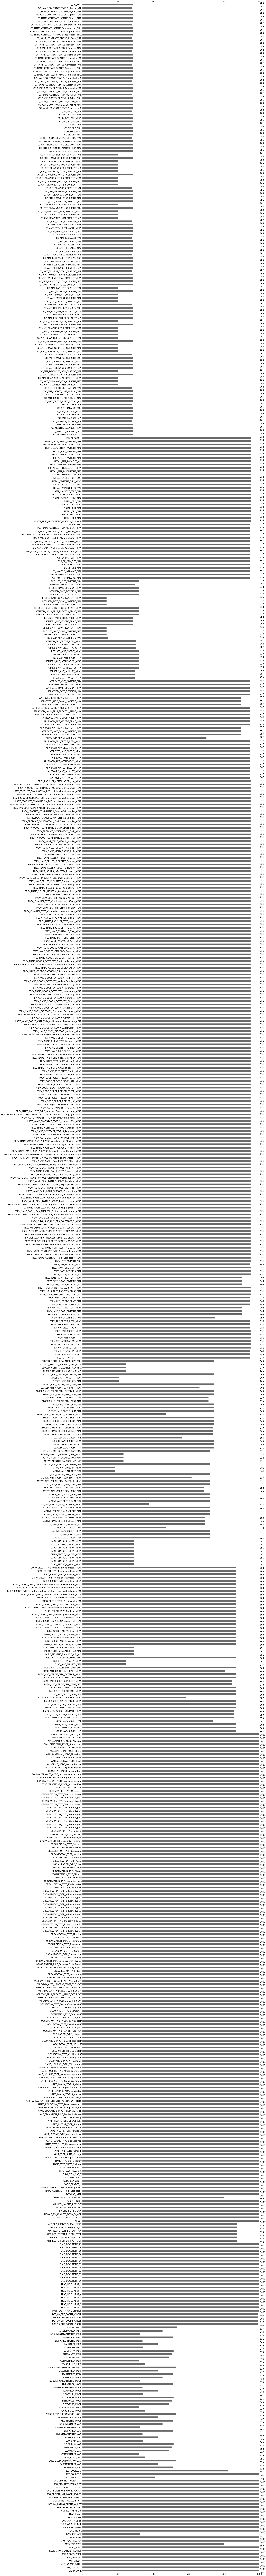

In [73]:
# mesure la corrélation de nullité 
import missingno as msno
msno.bar(df_data.sample(1000))

In [74]:
#Export des fichiers de données traités
output_dir = '/content/drive/MyDrive/DS_P7/'
df_data.to_csv(os.path.join(output_dir,'data_clean.csv'), index=False)
app_train_domain.to_csv(os.path.join(output_dir,'data_train.csv'), index=False)
app_test_domain.to_csv(os.path.join(output_dir,'data_test.csv'), index=False)